## QTLs mapped on coexpressed cluster PCs (pcQTLs) colocalize with new GWAS signals


In [1]:
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError 
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from scipy.stats import ttest_rel, ranksums
import networkx as nx
import os
from scipy.stats import ttest_ind
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from scipy.stats import ttest_rel, ttest_ind




from tqdm.auto import tqdm 
tqdm.pandas()

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

# colors
gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'FIBRBLS',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal

[(1.0, 0.6470588235294118, 0.30980392156862746),
 (0.9333333333333333, 0.6039215686274509, 0.0),
 (1.0, 0.0, 0.0),
 (0.6039215686274509, 0.7529411764705882, 0.803921568627451),
 (0.5450980392156862, 0.45098039215686275, 0.3333333333333333),
 (0.803921568627451, 0.6666666666666666, 0.49019607843137253),
 (0.6039215686274509, 0.803921568627451, 0.19607843137254902),
 (0.47843137254901963, 0.403921568627451, 0.9333333333333333),
 (1.0, 0.8431372549019608, 0.0),
 (0.22745098039215686, 0.37254901960784315, 0.803921568627451),
 (0.11764705882352941, 0.5647058823529412, 1.0),
 (0.0, 0.5450980392156862, 0.27058823529411763),
 (1.0, 0.0, 1.0)]

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

gwas_meta = pd.read_csv(config['gwas_meta'], sep='\t', header=0)
gwas_ids = gwas_meta['Tag']
coloc_cutoff = .75

### load in gwas coloc results

In [3]:
gwas_coloc = load_gwas_coloc(config)

File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.EGG_Pubertal_growth_10F.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GEFOS_Forearm.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.UKB_G43_Diagnoses_main_ICD10_G43_Migraine.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.GPC-NEO-NEUROTICISM.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Not_Sun_Exposed_Suprapubic/Skin_Not_Sun_Exposed_Suprapubic.v8.PGC_ASD_2017_CEU.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/

### aggregate over all PCs and egene for each gwas credible set

get the maximum coloc probability for each GWAS credible set with any egene or PC in the cluster

In [4]:
# aggregate over egenes and pcs
gwas_coloc_e = gwas_coloc[gwas_coloc['type']=='eqtl']
gwas_coloc_pc = gwas_coloc[gwas_coloc['type']=='pcqtl']
max_pph4_indices_e = gwas_coloc_e.groupby('gwas_tissue_cs_id')['PP.H4.abf'].idxmax()
max_pph4_indices_pc = gwas_coloc_pc.groupby('gwas_tissue_cs_id')['PP.H4.abf'].idxmax()

# set the pp4 to be the max of any pc or egene in the cluster
eqtl_pp4 = gwas_coloc.loc[max_pph4_indices_e, ['gwas_tissue_cs_id', 'PP.H4.abf']]
pcqtl_pp4 = gwas_coloc.loc[max_pph4_indices_pc, ['gwas_tissue_cs_id', 'PP.H4.abf']]
pph4 = pd.merge(pcqtl_pp4, eqtl_pp4, suffixes=['_pc','_e'], left_on='gwas_tissue_cs_id', right_on='gwas_tissue_cs_id', how='inner')
pph4['colocalized'] = (pph4['PP.H4.abf_e'] > coloc_cutoff)| (pph4['PP.H4.abf_pc'] >coloc_cutoff )
pph4['coloc_color'] = np.where(pph4['PP.H4.abf_e'] > coloc_cutoff, 
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'Both', 'eQTL only'),
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'pcQTL only', 'Neither'))

# print the percent in each category
print('pc only:{}'.format(((pph4['PP.H4.abf_pc']>coloc_cutoff) & (pph4['PP.H4.abf_e']<coloc_cutoff)).sum()/sum(pph4['colocalized'])))
print('e only:{}'.format(((pph4['PP.H4.abf_e']>coloc_cutoff) & (pph4['PP.H4.abf_pc']<coloc_cutoff)).sum()/sum(pph4['colocalized'])))
print('both: {}'.format(((pph4['coloc_color']=='Both')).sum()/sum(pph4['colocalized'])))
print('neither: {}'.format(((pph4['coloc_color']=='Neither')).sum()/len(pph4)))

pc only:0.24725274725274726
e only:0.2922077922077922
both: 0.46053946053946054
neither: 0.9849090169000919


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['matrix', 'shading', 'totals', 'intersections'])


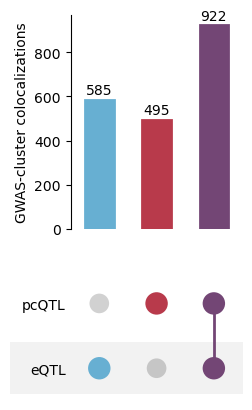

In [6]:
pph4['pcQTL'] = pph4['PP.H4.abf_pc'] > coloc_cutoff
pph4['eQTL'] = pph4['PP.H4.abf_e'] > coloc_cutoff
upset = pph4[~(pph4['coloc_color']=='Neither')].set_index('eQTL').set_index('pcQTL', append=True)
fig = plt.figure(figsize=(3,5))
upset = up.UpSet(upset, intersection_plot_elements=3, totals_plot_elements = 0, show_counts=True, element_size=None)  # disable the default bar chart
#upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=4, colors=('lightgrey', '#67AFD2','#016895'))
upset.style_subsets(present=["eQTL"], absent=["pcQTL"], facecolor="#67AFD2", linewidth=2)
upset.style_subsets(present=["pcQTL"], absent=["eQTL"], facecolor="#B83A4B", linewidth=2)
upset.style_subsets(present=["eQTL", "pcQTL"], facecolor="#734675", linewidth=2)

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

plot_result['intersections'].set_ylabel("GWAS-cluster colocalizations")

# style the totals plot
# upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper left')
leg = plt.gca().get_legend()
leg.set_title('')
leg.set_frame_on(False)

plt.show()

### pph4 per cluster plot

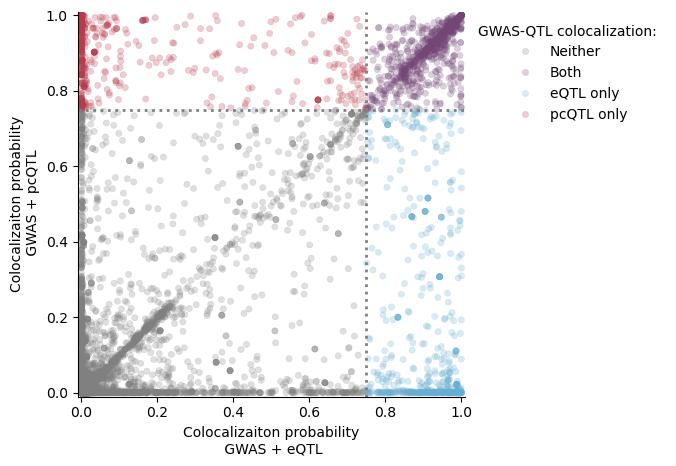

In [7]:
# plot th pp4s
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(pph4[pph4['coloc_color'].isin(['Neither', 'Both', 'eQTL only', 'pcQTL only'])], x='PP.H4.abf_e', y='PP.H4.abf_pc', hue='coloc_color', ax=ax, s=20, alpha=.25,
             palette={'pcQTL only':'#B83A4B', 'eQTL only':'#67AFD2', 'Both':'#734675', 'Neither':'grey'}, edgecolor=None,
             hue_order = ['Neither', 'Both', 'eQTL only', 'pcQTL only'])
ax.axhline(.75, color='grey', linestyle=':', linewidth=2)
ax.axvline(.75, color='grey', linestyle=':', linewidth=2)

ax.set_xlabel('Colocalizaiton probability\n GWAS + eQTL')
ax.set_ylabel('Colocalizaiton probability\n GWAS + pcQTL')

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01,1.01)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('GWAS-QTL colocalization: ')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

### group gwas to underlying signals

load in pairwise qtl coloc to get qtl groups, create a graph with qtl and gwas 

In [8]:
pair_coloc = load_across_tissues(config, load_pairwise_coloc)

gwas_coloc_hits = gwas_coloc[gwas_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
pair_coloc_hits = pair_coloc[pair_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()

underlying_signals = get_gwas_signals(gwas_coloc_hits, pair_coloc_hits)

/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_explode_gwas['gwas_type'] = underlying_signals_explode_gwas['cs_id'].str.split('gwas_').str[1].str.split('_cs').str[0]


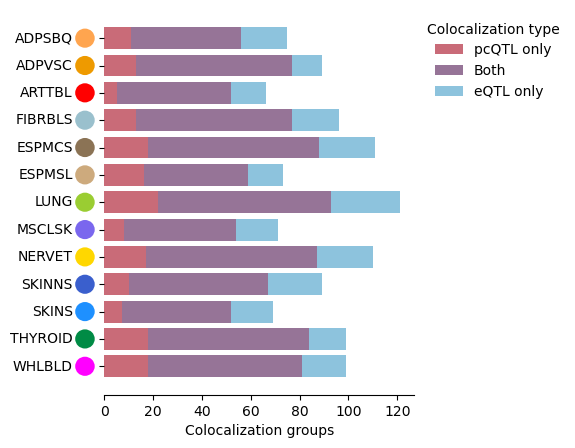

In [9]:
fig, ax = plt.subplots(figsize=(4, 5))

sns.histplot(underlying_signals, y='tissue_id', hue='type', multiple='stack',
            palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'both':'#734675'}, 
            shrink=.8, edgecolor=None, ax=ax, hue_order=['eqtl_only', 'both', 'pcqtl_only'])

# make the plot pretty
ax.spines[['top', 'left', 'right']].set_visible(False)
ax.set_xlabel('Colocalization groups')
ax.set_ylabel('')
ax.set_yticklabels('')

ax.legend(labels=['pcQTL only', 'Both', 'eQTL only'], title='Colocalization type', loc='upper left', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Add colored circles next to the y-ticks
for i, label in enumerate(gtex_tissue_abbrev):
    c = Ellipse((-8, i), 8, .7, clip_on=False, zorder=10, linewidth=0,
               edgecolor='none', facecolor=gtex_tissue_pal[i])
    ax.add_artist(c)
    ax.text(-13, i, label, verticalalignment='center', horizontalalignment='right')


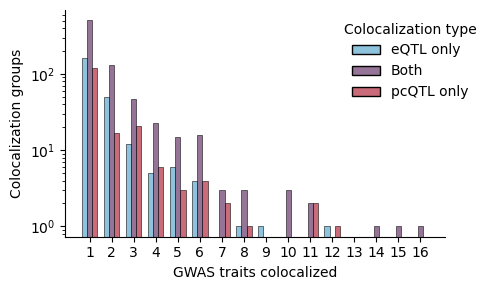

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.histplot(underlying_signals, x='gwas_type', hue='type', discrete=True, multiple='dodge', palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'both':'#734675'}, ax=ax, shrink=.7)
ax.set_yscale('log')
ax.set_xticks(np.arange(1, 17))
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('GWAS traits colocalized')
ax.set_ylabel('Colocalization groups')

sns.move_legend(ax, labels=['eQTL only', 'Both', 'pcQTL only'], title='Colocalization type', loc='upper left', frameon=False, bbox_to_anchor=(.7, 1))
fig.tight_layout()
plt.show()

### multigene more pleotopic

/local/scratch/klawren/slrmtmp.47876258/ipykernel_12827/1351738878.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(underlying_signals, x='gwas_type', y='num_e_coloc_clip',
/local/scratch/klawren/slrmtmp.47876258/ipykernel_12827/1351738878.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['single-eGene', 'multi-eGene'])


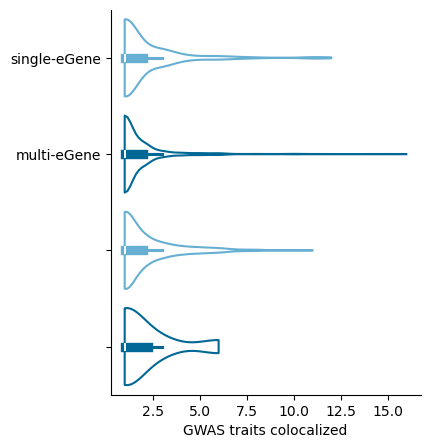

Ttest_indResult(statistic=2.7480208055824877, pvalue=0.006104592393971853)

In [22]:
# number of egenes vs number of gwas traits

fig, ax = plt.subplots(figsize=(4,5))
underlying_signals['num_e_coloc_clip'] = underlying_signals['num_e_coloc'].clip(0, 3)
sns.violinplot(underlying_signals, x='gwas_type', y='num_e_coloc_clip', 
               palette=('#67AFD2', '#016895'), ax=ax, cut=0, fill=False, orient='h', legend=False)


ax.set_xlabel('GWAS traits colocalized')
ax.set_ylabel("")
ax.set_yticklabels(['single-eGene', 'multi-eGene'])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


ttest_ind(underlying_signals[(underlying_signals['num_e_coloc']>0)&(underlying_signals['multiple_e'])]['gwas_type'], underlying_signals[(underlying_signals['num_e_coloc']>0)&~(underlying_signals['multiple_e'])]['gwas_type'])


Text(0.5, 0, 'GWAS traits colocalized')

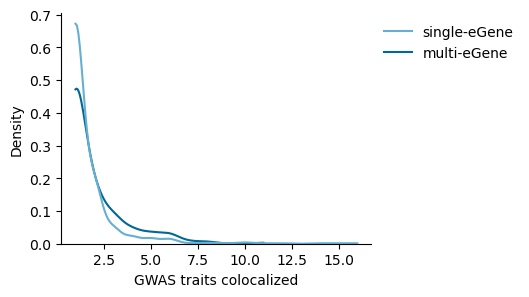

In [32]:
fig, ax = plt.subplots(figsize=(4,3))

sns.kdeplot(underlying_signals[underlying_signals['num_e_coloc']>0], x='gwas_type', hue='multiple_e', common_norm=False, cut=0, palette=('#67AFD2', '#016895'), ax=ax, hue_order=[False, True])
sns.move_legend(ax, title="", loc='upper left', bbox_to_anchor=(1, 1), frameon=False, labels=['single-eGene', 'multi-eGene'])

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('GWAS traits colocalized')


/local/scratch/klawren/slrmtmp.47748816/ipykernel_1097/70256533.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['single-eGene', 'multi-eGene'])


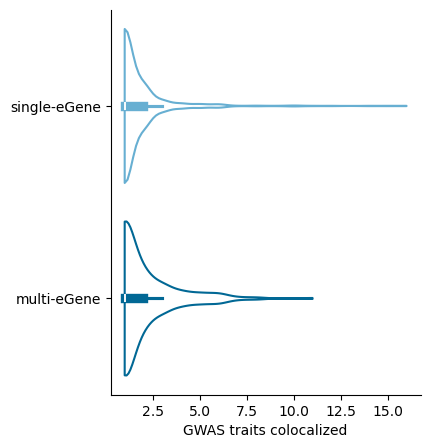

Ttest_indResult(statistic=2.7480208055824877, pvalue=0.006104592393971853)

In [255]:
fig, ax = plt.subplots(figsize=(4,5))

sns.violinplot(underlying_signals[underlying_signals['num_e_coloc']>0], x='gwas_type', hue='multiple_e', y='multiple_e', 
               palette=('#67AFD2', '#016895'), ax=ax, cut=0, fill=False, orient='h', legend=False)


ax.set_xlabel('GWAS traits colocalized')
ax.set_ylabel("")
ax.set_yticklabels(['single-eGene', 'multi-eGene'])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


ttest_ind(underlying_signals[(underlying_signals['num_e_coloc']>0)&(underlying_signals['multiple_e'])]['gwas_type'], underlying_signals[(underlying_signals['num_e_coloc']>0)&~(underlying_signals['multiple_e'])]['gwas_type'])

### gwas trait and tissue

In [258]:
underlying_signals_explode = underlying_signals.explode('cs_id')
underlying_signals_explode_gwas = underlying_signals_explode[underlying_signals_explode['cs_id'].str.contains('gwas')]
underlying_signals_explode_gwas['gwas_id'] = underlying_signals_explode_gwas['cs_id'].str.split('_cs').str[0]

/local/scratch/klawren/slrmtmp.47748816/ipykernel_1097/1999052844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_explode_gwas['gwas_id'] = underlying_signals_explode_gwas['cs_id'].str.split('_cs').str[0]


In [327]:
categories = {
    'neurological': [
        'UKB_1200_Sleeplessness_or_insomnia', 'UKB_20127_Neuroticism_score',
        'IGAP_Alzheimer', 'pgc.scz2', 'Jones_et_al_2016_SleepDuration',
        'SSGAC_Depressive_Symptoms', 'PGC_ADHD_EUR_2017'
    ],
    'anthropometric': [
        'GIANT_HEIGHT', 'GIANT_2015_BMI_EUR', 'UKB_21001_Body_mass_index_BMI',
        'UKB_23099_Body_fat_percentage', 'GIANT_WC_Combined_EUR',
        'UKB_20022_Birth_weight', 'UKB_20016_Fluid_intelligence_score',
        'GIANT_WHR_Combined_EUR','GIANT_HIP_Combined_EUR','GIANT_2017_BMI_Active_EUR'
    ],
    'immune-related': [
        'Astle_et_al_2016_Eosinophil_counts', 'Astle_et_al_2016_Lymphocyte_counts',
        'Astle_et_al_2016_Neutrophil_count', 'Astle_et_al_2016_Platelet_count',
        'Astle_et_al_2016_Granulocyte_count', 'Astle_et_al_2016_White_blood_cell_count',
        'IBD.EUR.Crohns_Disease', 'IBD.EUR.Inflammatory_Bowel_Disease',
        'IBD.EUR.Ulcerative_Colitis', 'EAGLE_Eczema', 'GABRIEL_Asthma',
        'UKB_6152_8_diagnosed_by_doctor_Asthma',
        'UKB_6152_9_diagnosed_by_doctor_Hayfever_allergic_rhinitis_or_eczema',
        'IMMUNOBASE_Systemic_lupus_erythematosus_hg19',
        'RA_OKADA_TRANS_ETHNIC','UKB_20002_1111_self_reported_asthma',
    ],
    'metabolic': [
        'MAGNETIC_HDL.C', 'MAGNETIC_LDL.C', 'GLGC_Mc_LDL', 'GLGC_Mc_HDL',
        'GLGC_Mc_TG', 'UKB_20002_1473_self_reported_high_cholesterol',
        'UKB_20002_1065_self_reported_hypertension', 'DIAGRAM_T2D_TRANS_ETHNIC',
        'CKDGen_Chronic_Kidney_Disease', 'MAGNETIC_IDL.TG'
    ],
    'hematopoietic': [
        'Astle_et_al_2016_Red_blood_cell_count', 'Astle_et_al_2016_Reticulocyte_count',
        'Astle_et_al_2016_Sum_neutrophil_eosinophil_counts',
        'Astle_et_al_2016_Sum_basophil_neutrophil_counts',
        'Astle_et_al_2016_Sum_eosinophil_basophil_counts',
        'Astle_et_al_2016_Monocyte_count',
        'Astle_et_al_2016_Myeloid_white_cell_count',
        'Astle_et_al_2016_High_light_scatter_reticulocyte_count'

    ],
    'cancer': [
        'BCAC_ER_negative_BreastCancer_EUR', 'BCAC_Overall_BreastCancer_EUR',
        'CARDIoGRAM_C4D_CAD_ADDITIVE'
    ],
    'cardiovascular': [
        'ICBP_DiastolicPressure', 'ICBP_SystolicPressure',
        'UKB_6150_1_Vascular_or_heart_problems_diagnosed_by_doctor_Heart_attack'
    ],
    'other': [
        'ADIPOGen_Adiponectin', 'MAGNETIC_CH2.DB.ratio', 'UKB_20002_1226_self_reported_hypothyroidism_or_myxoedema',
        'UKB_2395_4_Hair_or_balding_pattern_Pattern_4', 'EGG_BW3_EUR',
        'SSGAC_Education_Years_Pooled', 'UKB_1160_Sleep_duration',
        'UKB_20002_1466_self_reported_gout', 'UKB_20002_1453_self_reported_psoriasis',
        'UKB_20002_1094_self_reported_deep_venous_thrombosis_dvt',
        'UKB_6152_5_diagnosed_by_doctor_Blood_clot_in_the_leg_DVT',
        'UKB_6152_7_diagnosed_by_doctor_Blood_clot_in_the_lung',
        'UKB_20002_1309_self_reported_osteoporosis', 'UKB_2395_3_Hair_or_balding_pattern_Pattern_3',
        'UKB_1180_Morning_or_evening_person_chronotype', 'MAGNETIC_IDL.TG',
        'Jones_et_al_2016_Chronotype', 'HRGene_HeartRate','UKB_1807_Fathers_age_at_death','UKB_2395_2_Hair_or_balding_pattern_Pattern_2'
    ]
}

/local/scratch/klawren/slrmtmp.47748816/ipykernel_1097/4177031858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underlying_signals_explode_gwas['GWAS_category'] = underlying_signals_explode_gwas['gwas_id'].str.split('gwas_').str[1].map(trait_to_category)


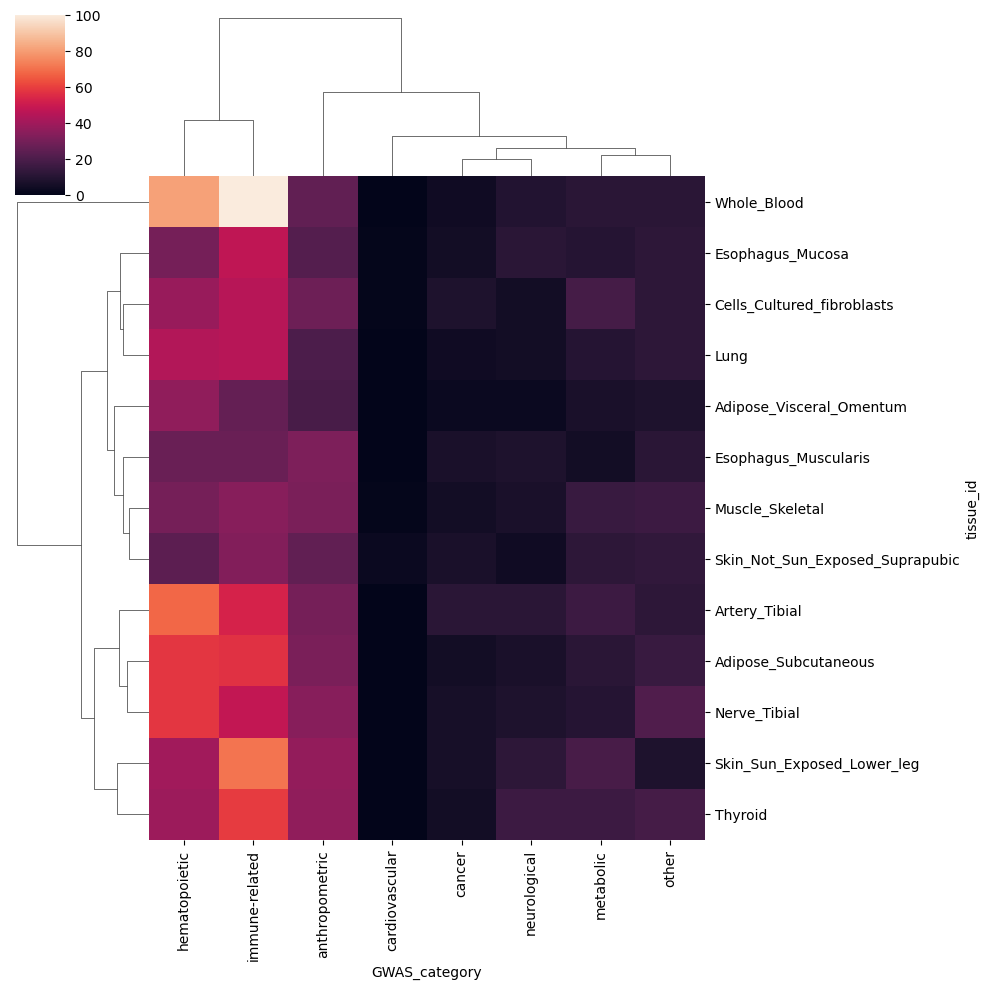

In [336]:
trait_to_category = {trait: category for category, trait_list in categories.items() for trait in trait_list}
underlying_signals_explode_gwas['GWAS_category'] = underlying_signals_explode_gwas['gwas_id'].str.split('gwas_').str[1].map(trait_to_category)

tissue_trait_counts = pd.DataFrame(underlying_signals_explode_gwas[['GWAS_category', 'tissue_id']].value_counts()).reset_index()
tissue_trait_counts = tissue_trait_counts.pivot_table(columns="GWAS_category", index="tissue_id", values="count", fill_value=0)

# high_gwas = (tissue_trait_counts.sum(axis=0) > 30)
# high_tissue_counts = tissue_trait_counts[tissue_trait_counts.columns[high_gwas]]
# print(high_tissue_counts.shape)
sns.clustermap(tissue_trait_counts)